# DATA GATHERING

In [221]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [222]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [223]:
df = pd.read_csv('/content/DATA_RAW.csv', engine='python', on_bad_lines='warn')

In [224]:
print("Jumlah baris:", df.shape)

Jumlah baris: (51305, 31)


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51305 entries, 0 to 51304
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   description                     50583 non-null  object 
 1   facilities_text                 29630 non-null  object 
 2   facility_jogging_track          8 non-null      object 
 3   facility_lapangan_basket        3 non-null      object 
 4   facility_lapangan_bulu_tangkis  2 non-null      object 
 5   fasilitas_perumahan_text        24871 non-null  object 
 6   fasilitas_rumah_text            27233 non-null  object 
 7   installment_info                50219 non-null  object 
 8   location                        50819 non-null  object 
 9   original_price                  3461 non-null   object 
 10  original_price_numeric          3461 non-null   float64
 11  perabotan_text                  17096 non-null  object 
 12  poi_perbelanjaan_text           

# RENAME FEATURE

In [226]:
def rename_feature(df):
    column_mapping = {
        'installment_info': 'monthly_installment_info',
        'price': 'price_display',
        'location': 'location',
        'savings': 'estimated_savings',
        'poi_structured_text': 'nearby_points_of_interest',
        'url': 'source_url',
        'updated_date': 'updatedAt',
        'facilities_text': 'facilities',
        'specifications_text':'specifications'
    }

    df.rename(columns=column_mapping, inplace=True)

    cols_to_drop = [
        'facility_jogging_track', 'facility_lapangan_tenis',
        'fasilitas_perumahan_text', 'fasilitas_rumah_text', 'perabotan_text',
        'poi_perbelanjaan_text', 'poi_sekolah_text', 'poi_text', 'poi_transportasi_text',
        'original_price', 'original_price_numeric', 'facility_lapangan_voli','facility_lapangan_basket',
        'facility_tempat_gym', 'facility_lapangan_bola ', 'facility_lapangan_bulu_tangkis'
    ]

    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

    if 'updatedAt' in df.columns:
        df['updatedAt'] = pd.to_datetime(df['updatedAt'], errors='coerce')

    return df

In [227]:
rename_df = rename_feature(df)

rename_df.to_csv('rename_df.csv', index=False)

<ipython-input-226-36e718407ea1>:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['updatedAt'] = pd.to_datetime(df['updatedAt'], errors='coerce')


In [228]:
rename_df.head(2)

,description,facilities,monthly_installment_info,location,nearby_points_of_interest,posted_by,price_display,price_numeric,property_type,estimated_savings,specifications,title,updatedAt,source_url,error,facility_lapangan_bola
0,Kesempatan terbatas buat Anda dapatkan rumah n...,"Taman, Tempat Jemuran, Teras, Telepon",Cicilan mulai Rp 120 Jutaan/bulan,"Jagakarsa, Jakarta Selatan","Transportasi: Stasiun Lenteng Agung, Stasiun T...",Ria Susanti,Rp 25 Miliar,2.500000e+10,Rumah,NaN,kamar tidur: 6; kamar mandi: 5; luas tanah: 13...,Rumah Jagakarsa 2 Lantai Taman & Carport Luas,NaT,https://www.rumah123.com/properti/jakarta-sela...,NaN,NaN
1,"Rumah READYSTOCK di Gandaria, Jakarta Selatan ...","Backyard, Taman, Tempat Cuci, Tempat Jemuran, ...",Cicilan mulai Rp 15 Jutaan/bulan,"Gandaria, Jakarta Selatan",NaN,Property Strategis,"Rp 3,15 Miliar",3.150000e+09,Rumah,NaN,kamar tidur: 4; kamar mandi: 4; luas tanah: 12...,Rumah Townhouse Jagakarsa Jakarta Selatan Deka...,2025-04-25,https://www.rumah123.com/properti/jakarta-sela...,NaN,NaN


In [229]:
rename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51305 entries, 0 to 51304
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   description                50583 non-null  object        
 1   facilities                 29630 non-null  object        
 2   monthly_installment_info   50219 non-null  object        
 3   location                   50819 non-null  object        
 4   nearby_points_of_interest  17157 non-null  object        
 5   posted_by                  50819 non-null  object        
 6   price_display              50819 non-null  object        
 7   price_numeric              50819 non-null  float64       
 8   property_type              50819 non-null  object        
 9   estimated_savings          3461 non-null   object        
 10  specifications             50819 non-null  object        
 11  title                      50815 non-null  object        
 12  upda

# EXTRACT FACILITIES

In [230]:
def extract_facilities(facilities_string):
    if pd.isna(facilities_string):
        return []
    return [facility.strip().lower() for facility in facilities_string.split(',')]

rename_df['facilities_list'] = rename_df['facilities'].apply(extract_facilities)
all_facilities = [item for sublist in rename_df['facilities_list'].tolist() for item in sublist]
unique_facilities = set(all_facilities)

prefix_to_remove = 'f_'
for col in rename_df.columns:
    if col.startswith(prefix_to_remove):
        rename_df.drop(columns=[col], inplace=True)

for facility in unique_facilities:
    clean_name = facility.replace(" ", "_").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").lower()
    feature_name = f'f_{clean_name}'

    rename_df[feature_name] = rename_df['facilities'].apply(
        lambda x: 1 if isinstance(x, str) and facility.lower() in x.lower() else 0
    )

rename_df.drop(columns=['facilities_list'], inplace=True)

In [231]:
print(f"Jumlah fitur fasilitas unik: {len(unique_facilities)}")

rename_df.head(2)

Jumlah fitur fasilitas unik: 29


,description,facilities,monthly_installment_info,location,nearby_points_of_interest,posted_by,price_display,price_numeric,property_type,estimated_savings,...,f_ac,f_tempat_gym,f_kolam_renang,f_masjid,f_jogging_track,f_kolam_ikan,f_mesin_cuci,f_lapangan_bola,f_telepon,f_lapangan_basket
0,Kesempatan terbatas buat Anda dapatkan rumah n...,"Taman, Tempat Jemuran, Teras, Telepon",Cicilan mulai Rp 120 Jutaan/bulan,"Jagakarsa, Jakarta Selatan","Transportasi: Stasiun Lenteng Agung, Stasiun T...",Ria Susanti,Rp 25 Miliar,2.500000e+10,Rumah,NaN,...,0,0,0,0,0,0,0,0,1,0
1,"Rumah READYSTOCK di Gandaria, Jakarta Selatan ...","Backyard, Taman, Tempat Cuci, Tempat Jemuran, ...",Cicilan mulai Rp 15 Jutaan/bulan,"Gandaria, Jakarta Selatan",NaN,Property Strategis,"Rp 3,15 Miliar",3.150000e+09,Rumah,NaN,...,1,0,0,0,0,0,0,0,1,0


In [232]:
rename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51305 entries, 0 to 51304
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   description                50583 non-null  object        
 1   facilities                 29630 non-null  object        
 2   monthly_installment_info   50219 non-null  object        
 3   location                   50819 non-null  object        
 4   nearby_points_of_interest  17157 non-null  object        
 5   posted_by                  50819 non-null  object        
 6   price_display              50819 non-null  object        
 7   price_numeric              50819 non-null  float64       
 8   property_type              50819 non-null  object        
 9   estimated_savings          3461 non-null   object        
 10  specifications             50819 non-null  object        
 11  title                      50815 non-null  object        
 12  upda

# EXTRACT SPECIFICATIONS

In [233]:
rename_df['specifications']

,specifications
0,kamar tidur: 6; kamar mandi: 5; luas tanah: 13...
1,kamar tidur: 4; kamar mandi: 4; luas tanah: 12...
2,kamar tidur: 8; kamar mandi: 7; luas tanah: 66...
3,kamar tidur: 4; kamar mandi: 3; luas tanah: 40...
4,kamar tidur: 5; kamar mandi: 5; luas tanah: 13...
...,...
51300,kamar tidur: 3; kamar mandi: 3; luas tanah: 71...
51301,kamar tidur: 3; kamar mandi: 2; luas tanah: 39...
51302,kamar tidur: 5; kamar mandi: 5; luas tanah: 33...
51303,kamar tidur: 4; kamar mandi: 3; luas tanah: 53...


In [234]:
unique_spec_items = set()

for spec in rename_df['specifications']:
    if pd.isna(spec):
        continue
    parts = spec.split(';')
    for part in parts:
        if ':' in part:
            key = part.split(':')[0].strip()
            unique_spec_items.add(key)

sorted_spec_items = sorted(unique_spec_items)

print("Item unik dalam kolom 'specifications':")
for item in sorted_spec_items:
    print(f"- {item}")

Item unik dalam kolom 'specifications':
- carport
- daya listrik
- garasi
- jumlah lantai
- kamar mandi
- kamar mandi pembantu
- kamar tidur
- kamar tidur pembantu
- kondisi properti
- luas bangunan
- luas tanah
- sertifikat


In [235]:
required_properties = [
    'carport', 'daya listrik', 'garasi', 'jumlah lantai',
    'kamar mandi', 'kamar mandi pembantu', 'kamar tidur',
    'kamar tidur pembantu', 'kondisi properti', 'luas bangunan',
    'luas tanah', 'sertifikat'
]

In [236]:
def parse_specifications(spec):
    if pd.isna(spec) or spec == "":
        return {}
    spec_dict = {}
    for part in spec.split(';'):
        if ':' in part:
            key, value = part.split(':', 1)
            normalized_key = key.strip().lower()
            cleaned_value = value.strip()
            # Coba konversi nilai ke numerik jika memungkinkan
            try:
                spec_dict[normalized_key] = int(cleaned_value)
            except ValueError:
                try:
                    spec_dict[normalized_key] = float(cleaned_value)
                except ValueError:
                    spec_dict[normalized_key] = cleaned_value # Biarkan sebagai string jika bukan numerik
    return spec_dict

# Terapkan fungsi parsing ke kolom 'specifications'
parsed_specs = rename_df['specifications'].apply(parse_specifications)

# Buat kolom baru untuk setiap properti yang dibutuhkan dengan nilai spesifik
for prop in required_properties:
    normalized_prop = prop.lower()
    feature_name = f's_{normalized_prop.replace(" ", "_")}' # Ubah nama kolom untuk menghindari konflik
    rename_df[feature_name] = parsed_specs.apply(lambda x: x.get(normalized_prop, None)) # Gunakan .get() untuk menghindari error jika kunci tidak ada

In [237]:
def clean_luas(luas_value):
    if pd.isna(luas_value):
        return None
    try:
        # Hapus "m²" dan spasi
        cleaned_value = str(luas_value).replace("m²", "").strip()
        # Konversi ke integer
        return int(cleaned_value)
    except ValueError:
        # Kembalikan None jika tidak dapat dikonversi
        return None

# Terapkan fungsi ke kolom luas_tanah
rename_df['s_luas_tanah'] = rename_df['s_luas_tanah'].apply(clean_luas)

# Terapkan fungsi ke kolom luas_bangunan
rename_df['s_luas_bangunan'] = rename_df['s_luas_bangunan'].apply(clean_luas)


In [238]:
rename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51305 entries, 0 to 51304
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   description                50583 non-null  object        
 1   facilities                 29630 non-null  object        
 2   monthly_installment_info   50219 non-null  object        
 3   location                   50819 non-null  object        
 4   nearby_points_of_interest  17157 non-null  object        
 5   posted_by                  50819 non-null  object        
 6   price_display              50819 non-null  object        
 7   price_numeric              50819 non-null  float64       
 8   property_type              50819 non-null  object        
 9   estimated_savings          3461 non-null   object        
 10  specifications             50819 non-null  object        
 11  title                      50815 non-null  object        
 12  upda

In [239]:
print(rename_df['s_daya_listrik'].head(10))

0      Lainnya
1    2200 Watt
2      Lainnya
3      Lainnya
4    3500 Watt
5      Lainnya
6    4400 Watt
7    2200 Watt
8      Lainnya
9    3500 Watt
Name: s_daya_listrik, dtype: object


In [240]:
rename_df.head(2)

,description,facilities,monthly_installment_info,location,nearby_points_of_interest,posted_by,price_display,price_numeric,property_type,estimated_savings,...,s_garasi,s_jumlah_lantai,s_kamar_mandi,s_kamar_mandi_pembantu,s_kamar_tidur,s_kamar_tidur_pembantu,s_kondisi_properti,s_luas_bangunan,s_luas_tanah,s_sertifikat
0,Kesempatan terbatas buat Anda dapatkan rumah n...,"Taman, Tempat Jemuran, Teras, Telepon",Cicilan mulai Rp 120 Jutaan/bulan,"Jagakarsa, Jakarta Selatan","Transportasi: Stasiun Lenteng Agung, Stasiun T...",Ria Susanti,Rp 25 Miliar,2.500000e+10,Rumah,NaN,...,2.0,2.0,5.0,4.0,6.0,5.0,Renovasi Minimum,1300.0,1300.0,SHM
1,"Rumah READYSTOCK di Gandaria, Jakarta Selatan ...","Backyard, Taman, Tempat Cuci, Tempat Jemuran, ...",Cicilan mulai Rp 15 Jutaan/bulan,"Gandaria, Jakarta Selatan",NaN,Property Strategis,"Rp 3,15 Miliar",3.150000e+09,Rumah,NaN,...,1.0,2.0,4.0,1.0,4.0,1.0,Bagus,190.0,128.0,SHM


# CLEAR MONTHLY INSTALLMENT FORMAT

In [241]:
def clean_monthly_installment(value):
    if pd.isna(value):
        return 0

    match = re.search(r'(\d+)\s*Jutaan', str(value))
    if match:
        juta = int(match.group(1))
        return juta * 1_000_000
    else:
        numbers = re.findall(r'\d+', str(value))
        if numbers:
            return int(numbers[0]) * 1_000_000
        return 0

rename_df['monthly_installment_info'] = rename_df['monthly_installment_info'].apply(clean_monthly_installment)

rename_df['monthly_installment_info'] = pd.to_numeric(rename_df['monthly_installment_info'], errors='coerce')

In [242]:
rename_df['monthly_installment_info'].unique()

array([120000000,  15000000, 168000000, 156000000,  72000000,  94000000,
         9000000,  91000000,  41000000, 265000000,  31000000, 255000000,
        17000000,  34000000,  52000000,  39000000,  33000000,  13000000,
         6000000,  26000000,  78000000,  11000000, 805000000,  25000000,
        53000000,  37000000,  32000000,   5000000,  38000000,   7000000,
        67000000, 132000000,   8000000, 110000000,  19000000,  18000000,
        82000000,  62000000,  23000000,  79000000,  74000000,  42000000,
        48000000,  57000000,  77000000, 337000000,  60000000,  10000000,
        16000000,  88000000, 424000000,   4000000, 159000000,  55000000,
       328000000,  12000000,  36000000,  45000000, 144000000,  21000000,
               0, 101000000,  96000000, 250000000,  51000000, 193000000,
        65000000, 241000000,  24000000, 188000000,  28000000, 142000000,
        20000000, 202000000, 429000000,  50000000,  84000000,  14000000,
       289000000,  29000000, 209000000,  95000000, 

# EXTRACT POI

In [243]:
non_null_values = rename_df[rename_df['nearby_points_of_interest'].notna()]['nearby_points_of_interest']

unique_values = set(non_null_values)

print(f"Jumlah data kosong: {rename_df['nearby_points_of_interest'].isna().sum()}\n")
print("Nilai unik di kolom 'nearby_points_of_interest':")
for value in sorted(unique_values):
    print(f"- {value}")


Jumlah data kosong: 34148

Nilai unik di kolom 'nearby_points_of_interest':
- Perbelanjaan: Borma Kopo
- Perbelanjaan: GDC
- Perbelanjaan: ICT Center Medan
- Perbelanjaan: Kampung Batik Trusmi
- Perbelanjaan: Koja Trade Mall; Sekolah: SMAN 13 Jakarta, SMKS Al Khairiyah 2
- Perbelanjaan: Lippo Mall Kemang
- Perbelanjaan: Lippo Mall Puri, PIM
- Perbelanjaan: Living World Alam Sutera
- Perbelanjaan: Mall of Indonesia, Summarecon Mall Kelapa Gading; Sekolah: SMAS Don Bosco 1
- Perbelanjaan: Medan Mall, Thamrin Plaza Medan, Olympia Plaza; Sekolah: SMA 1 Sutomo Medan
- Perbelanjaan: Metropolitan Mall Cileungsi
- Perbelanjaan: Naga Aqua Bekasi
- Perbelanjaan: Pakuwon Mall Surabaya, PTC Surabaya
- Perbelanjaan: Pasar Blauran Baru
- Perbelanjaan: Pasar Cibiuk Bandung; Sekolah: Universitas Telkom Bandung, Universitas Telkom (Tekom University), Student Center, SMK Telkom Bandung, International Class Academic Office (ICAO), Gate 4 TELKOM UNIVERSITY, Fakultas Komunikasi dan Bisnis Universitas Telko

In [244]:
rename_df['nearby_points_of_interest']

,nearby_points_of_interest
0,"Transportasi: Stasiun Lenteng Agung, Stasiun T..."
1,NaN
2,NaN
3,"Transportasi: MRT Asean, MRT Blok A, MRT Blok ..."
4,"Transportasi: MRT Fatmawati, MRT Haji Nawi, St..."
...,...
51300,NaN
51301,NaN
51302,"Transportasi: MRT Fatmawati, MRT Haji Nawi, St..."
51303,Transportasi: Pintu Tol Veteran; Sekolah: Moes...


In [245]:
from os import rename
import pandas as pd

def extract_poi_categories(poi_string):
    if pd.isna(poi_string) or poi_string == "":
        return set()
    categories = set()
    for item in poi_string.split(';'):
        if ':' in item:
            category = item.split(':')[0].strip().lower()
            categories.add(category)
    return categories

all_poi_categories = set()
for poi in rename_df['nearby_points_of_interest']:
    categories = extract_poi_categories(poi)
    all_poi_categories.update(categories)

for category in sorted(all_poi_categories):
    feature_name = f'poi_{category}'
    rename_df[feature_name] = rename_df['nearby_points_of_interest'].apply(
        lambda x: 1 if category in extract_poi_categories(x) else 0
    )

def clean_poi(value):
    if pd.isna(value) or value.strip() == "":
        return ""
    parts = value.split(';')
    cleaned_parts = []
    for part in parts:
        if ':' in part:
            content = part.split(':', 1)[1].strip()
        else:
            content = part.strip()
        cleaned_parts.append(content.lower())
    return '; '.join(cleaned_parts)

rename_df['nearby_points_of_interest'] = rename_df['nearby_points_of_interest'].apply(clean_poi)

rename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51305 entries, 0 to 51304
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   description                50583 non-null  object        
 1   facilities                 29630 non-null  object        
 2   monthly_installment_info   51305 non-null  int64         
 3   location                   50819 non-null  object        
 4   nearby_points_of_interest  51305 non-null  object        
 5   posted_by                  50819 non-null  object        
 6   price_display              50819 non-null  object        
 7   price_numeric              50819 non-null  float64       
 8   property_type              50819 non-null  object        
 9   estimated_savings          3461 non-null   object        
 10  specifications             50819 non-null  object        
 11  title                      50815 non-null  object        
 12  upda

# EXTRACT LOCATION

In [246]:
rename_df['location'].unique()

array(['Jagakarsa, Jakarta Selatan', 'Gandaria, Jakarta Selatan',
       'Pondok Indah, Jakarta Selatan', 'Kebayoran Baru, Jakarta Selatan',
       'Cilandak, Jakarta Selatan', 'Ragunan, Jakarta Selatan',
       'Cirendeu, Jakarta Selatan', 'Kemang, Jakarta Selatan',
       'Lebak Bulus, Jakarta Selatan', 'Kalibata, Jakarta Selatan',
       'Bintaro, Jakarta Selatan', 'Pesanggrahan, Jakarta Selatan',
       'Pejaten, Jakarta Selatan', 'Terogong, Jakarta Selatan',
       'Pondok Labu, Jakarta Selatan', 'Lenteng Agung, Jakarta Selatan',
       'Kebayoran Lama, Jakarta Selatan', 'Tebet, Jakarta Selatan',
       'Sektor 2 - Bintaro, Jakarta Selatan',
       'Mega Kuningan, Jakarta Selatan', 'Veteran, Jakarta Selatan',
       'Setiabudi, Jakarta Selatan', 'Sektor 5-Bintaro, Jakarta Selatan',
       'Sektor 1 - Bintaro, Jakarta Selatan', 'Ciganjur, Jakarta Selatan',
       'Ampera, Jakarta Selatan', 'Cinere, Jakarta Selatan',
       'Cipete, Jakarta Selatan', 'Tanjung Barat, Jakarta Selatan'

In [247]:


def extract_kabupaten(location):
    if pd.isna(location):
        return None
    try:
        kabupaten = location.split(',', 1)[1].strip().lower()
        return kabupaten
    except IndexError:
        return None

rename_df['kabupaten'] = rename_df['location'].apply(extract_kabupaten)

# Tampilkan hasil
print("Contoh data dengan fitur kabupaten:")
print(rename_df[['location', 'kabupaten']].head())

print("\nNilai unik di kolom 'kabupaten':")
print(rename_df['kabupaten'].unique())

Contoh data dengan fitur kabupaten:
                          location        kabupaten
0       Jagakarsa, Jakarta Selatan  jakarta selatan
1        Gandaria, Jakarta Selatan  jakarta selatan
2    Pondok Indah, Jakarta Selatan  jakarta selatan
3  Kebayoran Baru, Jakarta Selatan  jakarta selatan
4        Cilandak, Jakarta Selatan  jakarta selatan

Nilai unik di kolom 'kabupaten':
['jakarta selatan' None 'jakarta timur' 'jakarta utara' 'jakarta barat'
 'jakarta pusat' 'badung' 'balikpapan' 'bandar lampung' 'bandung'
 'banjarmasin' 'bantul' 'batam' 'bekasi' 'bogor' 'buleleng' 'cimahi'
 'cirebon' 'denpasar' 'depok' 'gianyar' 'gresik' 'jombang' 'makassar'
 'malang' 'medan' 'palu' 'pamekasan' 'pematang siantar' 'purwakarta'
 'semarang' 'serang' 'sidoarjo' 'sleman' 'solo' 'surabaya' 'tabanan'
 'tangerang selatan' 'tangerang' 'tuban' 'tulungagung' 'yogyakarta']


In [248]:

le = LabelEncoder()
rename_df['kabupaten_encoded'] = le.fit_transform(rename_df['kabupaten'].astype(str))

In [249]:
rename_df['kabupaten_encoded'].unique()

array([19,  0, 20, 21, 17, 18,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 38, 37, 39, 40, 41])

# EXTRACT ESTIMATED SAVINGS

In [250]:
rename_df['estimated_savings'].unique()

array([nan, 'Rp 1100 Miliaran', 'Rp 951 Jutaan', 'Rp 1000 Miliaran',
       'Rp 2501 Miliaran', 'Rp 1000 Jutaan', 'Rp 200 Jutaan',
       'Rp 650 Jutaan', 'Rp 500 Jutaan', 'Rp 7000 Miliaran',
       'Rp 8200 Miliaran', 'Rp 1200 Miliaran', 'Rp 3001 Miliaran',
       'Rp 100 Jutaan', 'Rp 5000 Miliaran', 'Rp 50 Jutaan',
       'Rp 700 Jutaan', 'Rp 4001 Miliaran', 'Rp 1501 Miliaran',
       'Rp 30 Jutaan', 'Rp 2500 Miliaran', 'Rp 1901 Miliaran',
       'Rp 451 Jutaan', 'Rp 651 Jutaan', 'Rp 150 Jutaan', 'Rp 300 Jutaan',
       'Rp 51 Jutaan', 'Rp 601 Jutaan', 'Rp 251 Jutaan', 'Rp 600 Jutaan',
       'Rp 151 Jutaan', 'Rp 250 Jutaan', 'Rp 301 Jutaan', 'Rp 900 Jutaan',
       'Rp 3000 Miliaran', 'Rp 501 Jutaan', 'Rp 4000 Miliaran',
       'Rp 1001 Miliaran', 'Rp 20 Jutaan', 'Rp 476 Jutaan',
       'Rp 2001 Miliaran', 'Rp 350 Jutaan', 'Rp 1211 Miliaran',
       'Rp 1050 Miliaran', 'Rp 450 Jutaan', 'Rp 1300 Miliaran',
       'Rp 1380 Miliaran', 'Rp 701 Jutaan', 'Rp 401 Jutaan',
       'Rp 400 Ju

In [251]:


def clean_estimated_savings(value):
    if pd.isna(value):
        return 0

    value = str(value).lower()

    juta_match = re.search(r'(\d+[\d,.]*)\s*juta', value)
    miliar_match = re.search(r'(\d+[\d,.]*)\s*miliar', value)
    ribu_match = re.search(r'(\d+[\d,.]*)\s*ribu', value)

    if juta_match:
        number = float(juta_match.group(1).replace(',', '.'))
        return number * 1_000_000
    elif miliar_match:
        number = float(miliar_match.group(1).replace(',', '.'))
        return number * 1_000_000_000
    elif ribu_match:
        number = float(ribu_match.group(1).replace(',', '.'))
        return number * 1_000
    else:
        numbers = re.findall(r'\d+[\d,.]*', value)
        if numbers:
            number = float(numbers[0].replace(',', '.'))
            return number
        return 0

rename_df['estimated_savings'] = rename_df['estimated_savings'].apply(clean_estimated_savings)

rename_df['estimated_savings'] = pd.to_numeric(rename_df['estimated_savings'], errors='coerce')

In [259]:
rename_df['estimated_savings']

,estimated_savings
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
51300,0.0
51301,0.0
51302,0.0
51303,0.0


# Mengapus data null, kolom yang banyak null dan outlier

In [263]:
# Simpan pengaturan tampilan saat ini untuk display.max_rows
original_max_rows = pd.get_option('display.max_rows')

# Atur opsi display.max_rows ke None untuk memastikan semua baris (kolom) ditampilkan
pd.set_option('display.max_rows', None)

# Hitung dan cetak jumlah nilai null untuk setiap kolom
# Output ini adalah Series pandas, display.max_rows mengontrol berapa banyak item dalam Series yang ditampilkan
print(rename_df.isnull().sum())

# Kembalikan pengaturan tampilan ke nilai aslinya
pd.set_option('display.max_rows', original_max_rows)

description                    722
facilities                   21675
monthly_installment_info         0
location                       486
nearby_points_of_interest        0
posted_by                      486
price_display                  486
price_numeric                  486
property_type                  486
estimated_savings                0
specifications                 486
title                          490
updatedAt                    44661
source_url                       0
error                        50819
facility_lapangan_bola       51304
f_taman_bermain                  0
f_cctv                           0
f_keamanan_24_jam                0
f_tempat_cuci                    0
f_taman                          0
f_laundry                        0
f_kitchen_set                    0
f_akses_parkir                   0
f_kulkas                         0
f_lapangan_tenis                 0
f_kompor                         0
f_wastafel                       0
f_water_heater      

In [265]:
# Identifikasi kolom dengan lebih dari 5000 nilai null
cols_to_drop_by_nulls = rename_df.columns[rename_df.isnull().sum() > 4000]

# Hapus kolom-kolom tersebut
rename_df.drop(columns=cols_to_drop_by_nulls, inplace=True)

print(f"Jumlah kolom yang dihapus karena nilai null > 5000: {len(cols_to_drop_by_nulls)}")
print("Kolom yang dihapus:")
for col in cols_to_drop_by_nulls:
    print(f"- {col}")

# Verifikasi dengan menampilkan info terbaru
rename_df.info()

# Verifikasi dengan menampilkan jumlah nulls terbaru
print("\nJumlah nilai null setelah penghapusan:")
print(rename_df.isnull().sum())

Jumlah kolom yang dihapus karena nilai null > 5000: 1
Kolom yang dihapus:
- s_kondisi_properti
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51305 entries, 0 to 51304
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   description                50583 non-null  object 
 1   monthly_installment_info   51305 non-null  int64  
 2   location                   50819 non-null  object 
 3   nearby_points_of_interest  51305 non-null  object 
 4   posted_by                  50819 non-null  object 
 5   price_display              50819 non-null  object 
 6   price_numeric              50819 non-null  float64
 7   property_type              50819 non-null  object 
 8   estimated_savings          51305 non-null  float64
 9   specifications             50819 non-null  object 
 10  title                      50815 non-null  object 
 11  source_url                 51305 non-null  object 
 12  f_taman

In [266]:
# Hapus baris yang memiliki nilai null
rename_df.dropna(inplace=True)

print("\nJumlah baris setelah menghapus baris dengan nilai null:", rename_df.shape[0])
print("\nJumlah nilai null setelah menghapus baris dengan nilai null:")
print(rename_df.isnull().sum())



Jumlah baris setelah menghapus baris dengan nilai null: 46866

Jumlah nilai null setelah menghapus baris dengan nilai null:
description                  0
monthly_installment_info     0
location                     0
nearby_points_of_interest    0
posted_by                    0
price_display                0
price_numeric                0
property_type                0
estimated_savings            0
specifications               0
title                        0
source_url                   0
f_taman_bermain              0
f_cctv                       0
f_keamanan_24_jam            0
f_tempat_cuci                0
f_taman                      0
f_laundry                    0
f_kitchen_set                0
f_akses_parkir               0
f_kulkas                     0
f_lapangan_tenis             0
f_kompor                     0
f_wastafel                   0
f_water_heater               0
f_tempat_jemuran             0
f_lapangan_bulu_tangkis      0
f_backyard                   0
f_teras

In [267]:
# prompt: hitung outlier setiap kolom

def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Pilih kolom numerik yang ingin diperiksa outliernya
numeric_cols = rename_df.select_dtypes(include=['int64', 'float64']).columns

print("Finding outliers for numeric columns:")
for col in numeric_cols:
    outliers = find_outliers_iqr(rename_df, col)
    print(f"\nOutliers in '{col}':")
    if not outliers.empty:
        print(f"  Number of outliers: {len(outliers)}")
        print(f"  Percentage of outliers: {(len(outliers) / len(rename_df) * 100):.2f}%")
        # print(outliers[[col]]) # Uncomment if you want to see the actual outlier rows
    else:
        print("  No outliers found.")


Finding outliers for numeric columns:

Outliers in 'monthly_installment_info':
  Number of outliers: 5126
  Percentage of outliers: 10.94%

Outliers in 'price_numeric':
  Number of outliers: 5157
  Percentage of outliers: 11.00%

Outliers in 'estimated_savings':
  Number of outliers: 3261
  Percentage of outliers: 6.96%

Outliers in 'f_taman_bermain':
  Number of outliers: 3693
  Percentage of outliers: 7.88%

Outliers in 'f_cctv':
  Number of outliers: 8817
  Percentage of outliers: 18.81%

Outliers in 'f_keamanan_24_jam':
  No outliers found.

Outliers in 'f_tempat_cuci':
  Number of outliers: 4796
  Percentage of outliers: 10.23%

Outliers in 'f_taman':
  No outliers found.

Outliers in 'f_laundry':
  Number of outliers: 4690
  Percentage of outliers: 10.01%

Outliers in 'f_kitchen_set':
  Number of outliers: 10670
  Percentage of outliers: 22.77%

Outliers in 'f_akses_parkir':
  Number of outliers: 10555
  Percentage of outliers: 22.52%

Outliers in 'f_kulkas':
  Number of outliers

# SPLIT DF TO DF_SPECS AND DF_FACILITIES

In [269]:
rename_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46866 entries, 0 to 51304
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   description                46866 non-null  object 
 1   monthly_installment_info   46866 non-null  int64  
 2   location                   46866 non-null  object 
 3   nearby_points_of_interest  46866 non-null  object 
 4   posted_by                  46866 non-null  object 
 5   price_display              46866 non-null  object 
 6   price_numeric              46866 non-null  float64
 7   property_type              46866 non-null  object 
 8   estimated_savings          46866 non-null  float64
 9   specifications             46866 non-null  object 
 10  title                      46866 non-null  object 
 11  source_url                 46866 non-null  object 
 12  f_taman_bermain            46866 non-null  int64  
 13  f_cctv                     46866 non-null  int64  


Ada perubahan karena daya listrik, kondisi properti dan sertifikat itu srting

In [270]:
# Filter out non-numeric columns explicitly before creating the dataframes
spec_columns = [col for col in rename_df.columns if col.startswith('s_')]
facility_columns = [col for col in rename_df.columns if col.startswith('f_')]
base_columns = ['monthly_installment_info', 'kabupaten_encoded', 'price_numeric', 'estimated_savings']

# Identify columns to include in df_specs and df_facilities
df_specs_cols = base_columns + spec_columns
df_facilities_cols = base_columns + facility_columns

# Create copies of the dataframes
df_specs = rename_df[df_specs_cols].copy()
df_facilities = rename_df[df_facilities_cols].copy()

# Konversi semua kolom di df_specs ke numerik, ubah nilai non-numerik menjadi NaN
for col in df_specs.columns:
    df_specs[col] = pd.to_numeric(df_specs[col], errors='coerce')

# Konversi semua kolom di df_facilities ke numerik, ubah nilai non-numerik menjadi NaN
for col in df_facilities.columns:
    df_facilities[col] = pd.to_numeric(df_facilities[col], errors='coerce')


print("Info df_specs:")
df_specs.info()
print("\nInfo df_facilities:")
df_facilities.info()


Info df_specs:
<class 'pandas.core.frame.DataFrame'>
Index: 46866 entries, 0 to 51304
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   monthly_installment_info  46866 non-null  int64  
 1   kabupaten_encoded         46866 non-null  int64  
 2   price_numeric             46866 non-null  float64
 3   estimated_savings         46866 non-null  float64
 4   s_daya_listrik            0 non-null      float64
 5   s_jumlah_lantai           46866 non-null  float64
 6   s_kamar_mandi             46866 non-null  float64
 7   s_kamar_tidur             46866 non-null  float64
 8   s_luas_bangunan           46866 non-null  float64
 9   s_luas_tanah              46866 non-null  float64
 10  s_sertifikat              0 non-null      float64
dtypes: float64(9), int64(2)
memory usage: 4.3 MB

Info df_facilities:
<class 'pandas.core.frame.DataFrame'>
Index: 46866 entries, 0 to 51304
Data columns (total 33 c

# EDA

In [271]:
corr_specs = df_specs.corr()
corr_facilities = df_facilities.corr()

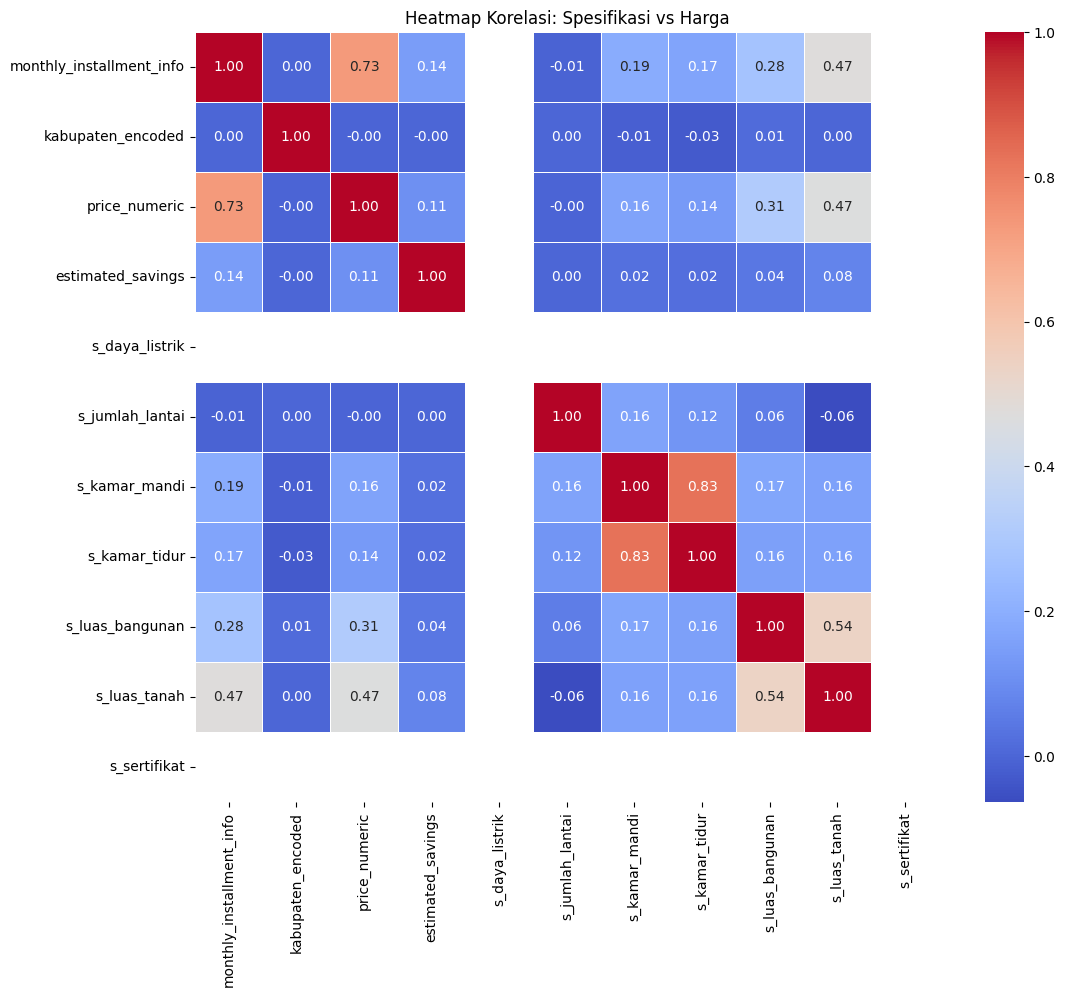

In [272]:


plt.figure(figsize=(12, 10))
sns.heatmap(corr_specs, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap Korelasi: Spesifikasi vs Harga")
plt.show()

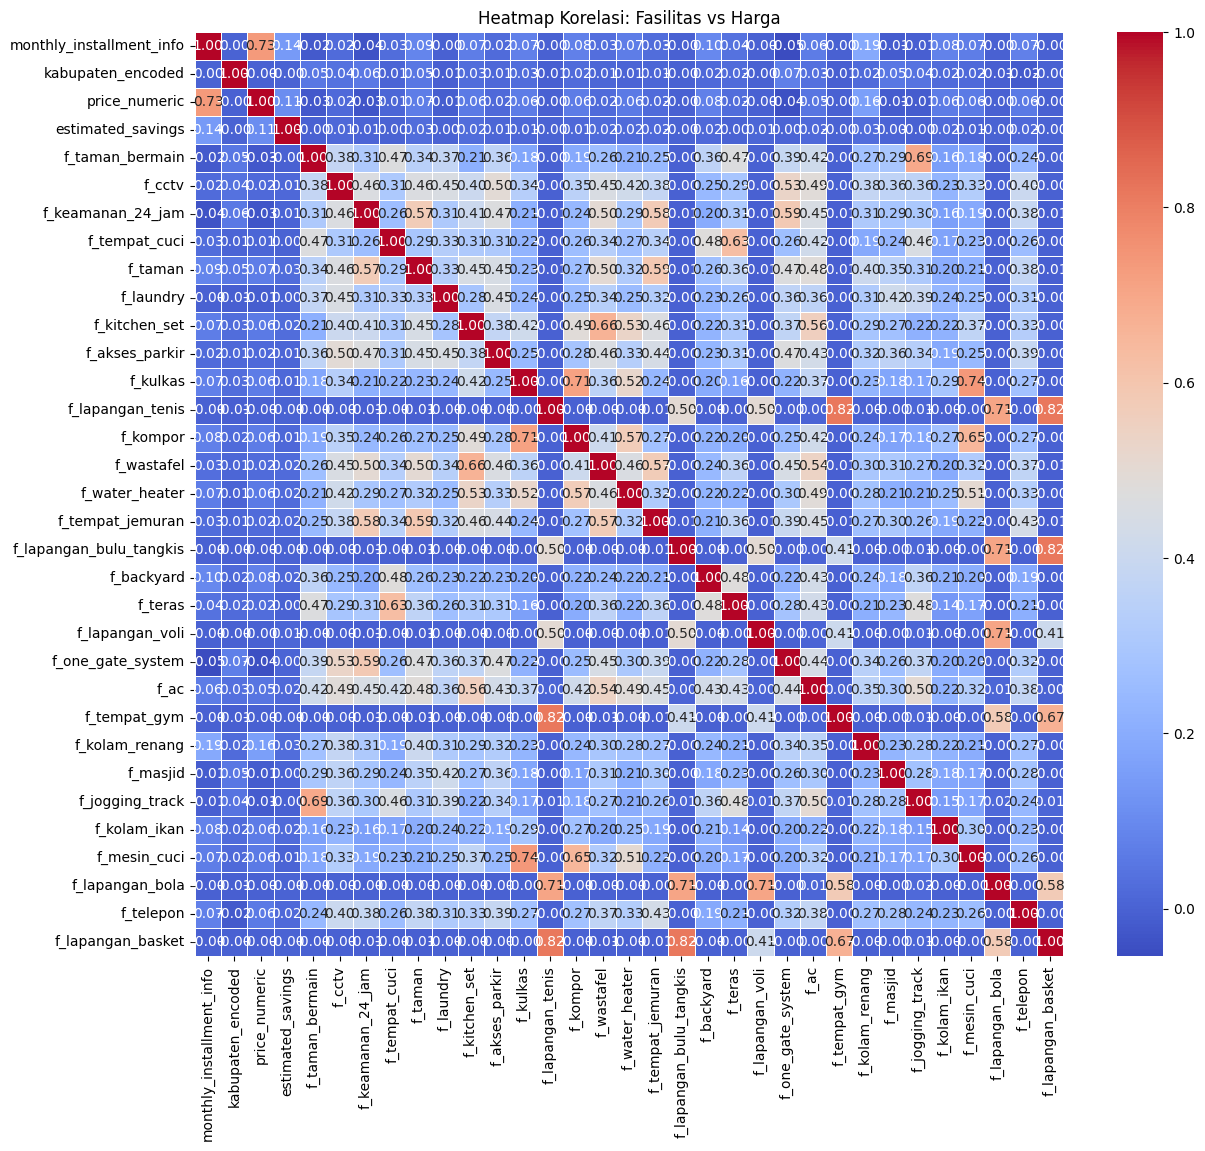

In [273]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr_facilities, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap Korelasi: Fasilitas vs Harga")
plt.show()

In [274]:
price_corr_specs = corr_specs[['price_numeric']].drop('price_numeric') # Hilangkan korelasi 1 dengan dirinya sendiri
price_corr_facilities = corr_facilities[['price_numeric']].drop('price_numeric') # Hilangkan korelasi 1 dengan dirinya sendiri

all_price_correlations = pd.concat([price_corr_specs, price_corr_facilities])

ranked_correlations = all_price_correlations.squeeze().abs().sort_values(ascending=False)

ranked_correlations_with_sign = all_price_correlations.loc[ranked_correlations.index].squeeze()

unique_correlations = ranked_correlations_with_sign[~ranked_correlations_with_sign.index.duplicated(keep='first')]

print("Korelasi Unik dengan Price_Numeric (Tanpa Duplikat, Berdasarkan Ranking Absolut):")
unique_correlations

Korelasi Unik dengan Price_Numeric (Tanpa Duplikat, Berdasarkan Ranking Absolut):


,price_numeric
monthly_installment_info,0.733600
s_luas_tanah,0.465150
s_luas_bangunan,0.313281
s_kamar_mandi,0.162746
f_kolam_renang,0.157608
s_kamar_tidur,0.138758
estimated_savings,0.109239
f_backyard,0.075141
f_taman,0.069194
f_kompor,0.064511


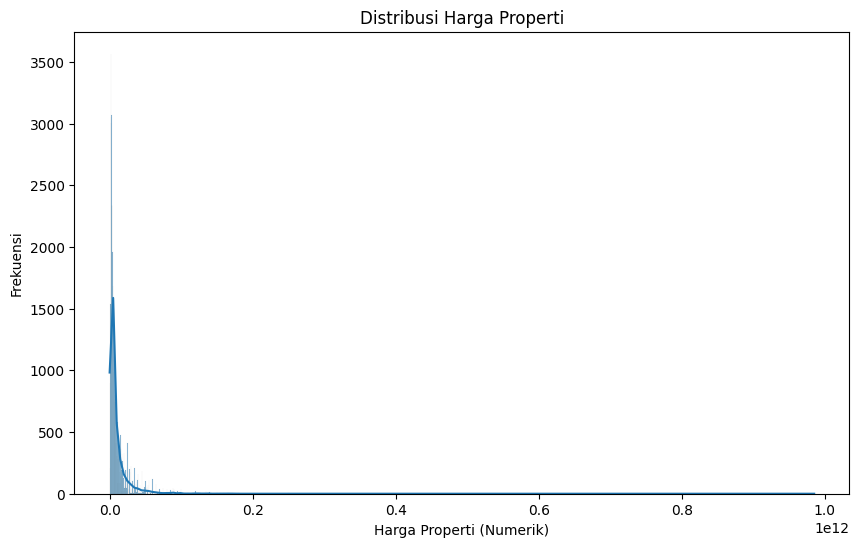

In [275]:
plt.figure(figsize=(10, 6))
sns.histplot(rename_df['price_numeric'], kde=True)
plt.title('Distribusi Harga Properti')
plt.xlabel('Harga Properti (Numerik)')
plt.ylabel('Frekuensi')
plt.show()


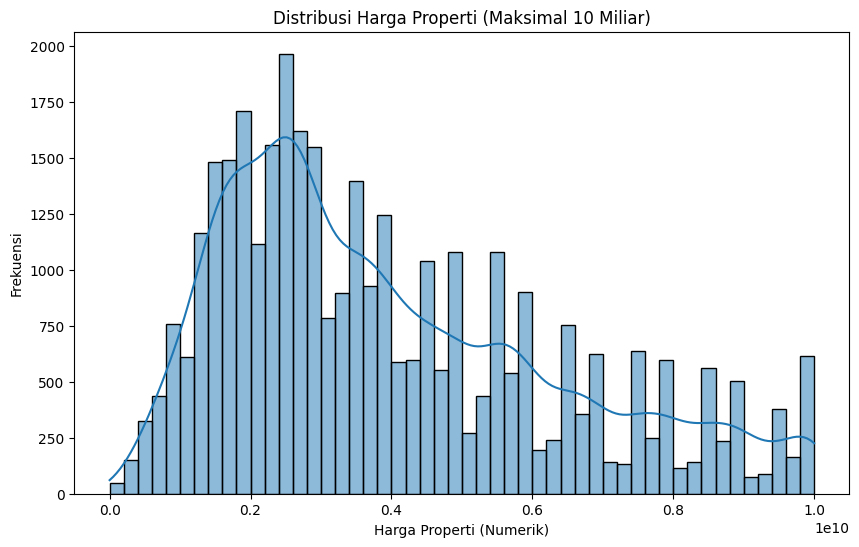

In [276]:
# Filter data dengan harga di bawah 10 miliar
df_filtered_price = rename_df[rename_df['price_numeric'] <= 10_000_000_000]

# Buat plot distribusi harga untuk data yang difilter
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered_price['price_numeric'], kde=True, bins=50) # Sesuaikan bins sesuai kebutuhan
plt.title('Distribusi Harga Properti (Maksimal 10 Miliar)')
plt.xlabel('Harga Properti (Numerik)')
plt.ylabel('Frekuensi')
plt.show()